#  Pawnee Fire Analysis

> * 🔬 Data Science
* 🖥️ Requires RasterAnalytics Portal Configuration
* 🖥️ Requires GeoEnrichment Portal Configuration
* 🖥️ Requires GeoAnalytics Portal Configuration

The Pawnee Fire was a large wildfire that burned in Lake County, California. The fire started on June 23, 2018 and burned a total of 15,185 acres (61 km2) before it was fully contained on July 8, 2018.

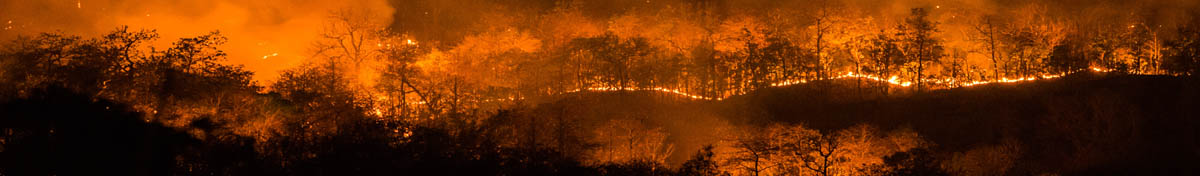

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Pawnee-Fire-analysis" data-toc-modified-id="Pawnee-Fire-analysis-1">Pawnee Fire Analysis</a></span><ul class="toc-item"><li><span><a href="#Remote-Sensing-using-Sentinel-2-data" data-toc-modified-id="Remote-Sensing-using-Sentinel-2-data-1.1">Remote Sensing using Sentinel-2 data</a></span></li><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-1.2">Data Preparation</a></span></li><li><span><a href="#Visual-Assessment" data-toc-modified-id="Visual-Assessment-1.3">Visual Assessment</a></span></li><li><span><a href="#Quantitative-Assessment" data-toc-modified-id="Quantitative-Assessment-1.4">Quantitative Assessment</a></span></li><li><span><a href="#Impact-Assessment" data-toc-modified-id="Impact-Assessment-1.5">Impact Assessment</a></span></ul></li>
<li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-2">Conclusion</a></span></li></ul></div>

## Remote Sensing using Sentinel-2 data

In [1]:
from datetime import datetime
import warnings

from IPython.display import HTML
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import arcgis
from arcgis import GIS
from arcgis.raster.functions import *
from arcgis.geoanalytics.use_proximity import create_buffers
from arcgis.geoenrichment import enrich
from arcgis.features import SpatialDataFrame
from arcgis.raster.analytics import create_image_collection
from arcgis.raster.analytics import list_datastore_content

gis= GIS('home')
age_pyramid(impacted_people);

# Conclusion

In this notebook example, we used Sentinel-2 data in order to perform remote sensing. For this we filtered out pre and post fire scenes. Using extract_band() we carried out visual assessment of the burnt area. We then computed the NBR on these scenes and computed the NBR difference to identify places that have been affected by the fire, using raster functions. We also normalized the values to match the burn severity index, applied a color map raster function that brings out the extent of fire damage and calculated the burnt area. Finally, we carried out a human impact assessment by plotting the age pyramid of affected population 




![](img/wildfire_banner.jpg)